# Análise dos dados de Aluguel do QuintoAndar
***

## Motivação e proposta

+ Nesse projeto desenvolvi um Algoritmo de Machine Learning capaz de recomendar o valor a se cobrar no aluguel de um imóvel a partir de suas características (nº de quartos, vaga na garagem, metragem, etc). Para isso, a partir dos cinceitos de ETl (Extract-Transform-Load), extraí os dados de imóveis localizados em São Paulo no aplicativo [QuintoAndar](http://quintoandar.com.br/), explorei-os estatísticamente e depois, escolhi o melhor algoritmo para o trabalho.
+ Esse projeto tem utilidade para que os usuários saibam qual o valor de mercado esperado para seus imóveis no momento de anúnciar. Além disso, é de grande importância para meu aprendizado, colocando à prova meus conhecimentos até hoje estudados.

## Dados

Os dados aqui utilizados foram extraídos do site do QuintoAndar pelo uso de seu API interno, estando já prontos para importação no arquivo `aluguel_unique.csv` e a única preparação feita anteriormente foi a remoção de linhas duplicadas nas respostas do API.

## Estrutura do Notebook

**1. Importações**

**2. Análise exploratória:**

Nesse momento tenta-se conhecer melhor o dataset, a partir de:

* Entender informações básicas do dataset, como tamanho, quais as variáveis, etc. E definir quais colunas utilizar.
* Conferir se há dados faltantes, se será preciso transformar alguma variável, etc.
* Análises estatísticas
   
**3. Formulação das hipóteses**

Hipóteses sobre os dados serão formuladas
    
**4. Seleção de features para Machine Learning**

Escolher quais colunas do dataset serão realmente utilizadas. Conferir as correlações entre elas e se preciso, transformar variáveis categóricas. 

**5. Teste de diversos algoritmos de Machine Learning**

Aplica-se uma série de algoritmos e conferimos suas taxas de acerto, com isso, definiremos qual o melhor algoritmo para a proposta do projeto.
    
**6. Criação de um Pipeline para deploy**

Escolhido o algoritmo, criamos um pipeline com todo o processo de transformação e aplicação do mesmo para poder-mos fazer o deploy posteriormente.
    
**7. Conclusão do projeto**

Considerações finais do projeto.

## 1. Importações

In [1]:
import pandas                as pd
import seaborn               as sns
import matplotlib.pyplot     as plt
import matplotlib.ticker     as mtick
import numpy                 as np
import warnings
import gc                    #usarei o Garbage Collector para forçar a limpeza de memória e garantir que não teremos erros
from IPython.display         import Markdown, display
from sklearn.ensemble        import RandomForestClassifier
from sklearn.preprocessing   import LabelEncoder, OneHotEncoder, PolynomialFeatures, FunctionTransformer
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.linear_model    import LinearRegression, Ridge, RidgeCV ,SGDRegressor
from sklearn.pipeline        import make_pipeline
from sklearn.preprocessing   import StandardScaler
from boruta                  import BorutaPy

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
#Para poder estruturar alguns outputs irei utilizar essa função simples feita pelo user Charles no StackOverflow (https://stackoverflow.com/a/46934204)
def printmd(string, color=None):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

In [3]:
db = pd.read_csv('../CSV/aluguel_unique.csv')

## 2. Análise exploratória

In [4]:
print('O dataset tem : {linhas} linhas e {colunas} colunas'.format(linhas=db.shape[0],colunas=db.shape[1]))

O dataset tem : 10034 linhas e 22 colunas


In [5]:
db.columns

Index(['Unnamed: 0', '_id', 'id', 'fields.quartos', 'fields.endereco',
       'fields.id', 'fields.photo_titles', 'fields.tipo', 'fields.area',
       'fields.for_rent', 'fields.sale_price', 'fields.aluguel',
       'fields.foto_capa', 'fields.photos', 'fields.custo', 'fields.cidade',
       'fields.visit_status', 'fields.for_sale', 'fields.condo_iptu',
       'fields.vagas', 'fields.listing_tags', 'fields.regiao_nome'],
      dtype='object')

In [6]:
db.sample(2)

,Unnamed: 0,_id,id,fields.quartos,fields.endereco,fields.id,fields.photo_titles,fields.tipo,fields.area,fields.for_rent,fields.sale_price,fields.aluguel,fields.foto_capa,fields.photos,fields.custo,fields.cidade,fields.visit_status,fields.for_sale,fields.condo_iptu,fields.vagas,fields.listing_tags,fields.regiao_nome
9055,9055,6021ee1d3d6af61e72c97b46,893226204,3,Rua Fradique Coutinho,893226204,"[""Sala"",""Sala"",""Sala"",""Sala"",""Sala""]",Apartamento,130,True,false,5950,capa893226204592_5580237014622021_01Beritheia5...,"[""893226204-592.5580237014622021.01Beritheia5A...",8759,São Paulo,ACCEPT_NEW,False,2614,3,"[""RENT_PRICE_DECREASED""]",Vila Madalena
6056,6056,6021ee1d3d6af61e72c96f8f,892988686,true,Rua Catumbi,892988686,"[""Sala"",""Sala"",""Sala"",""Varanda Sala"",""Quarto""]",Apartamento,32,True,false,1300,capa892988686520_9124767260118LUI8276.jpg,"[""892988686-520.9124767260118LUI8276.jpg"",""892...",1643,São Paulo,ACCEPT_NEW,False,300,false,"[""RENT_PRICE_DECREASED""]",Belém


In [7]:
db.dtypes

Unnamed: 0              int64
_id                    object
id                      int64
fields.quartos         object
fields.endereco        object
fields.id               int64
fields.photo_titles    object
fields.tipo            object
fields.area            object
fields.for_rent          bool
fields.sale_price      object
fields.aluguel         object
fields.foto_capa       object
fields.photos          object
fields.custo           object
fields.cidade          object
fields.visit_status    object
fields.for_sale          bool
fields.condo_iptu      object
fields.vagas           object
fields.listing_tags    object
fields.regiao_nome     object
dtype: object

In [8]:
# Vamos entender porque existem tantas colunas numéricas com dtype de object
# Já removi algumas colunas que não são de nosso interesse, como nome das photos, etc
colunas = ['id', 'fields.quartos', 'fields.endereco',
       'fields.tipo', 'fields.area',
       'fields.for_rent', 'fields.sale_price',
       'fields.aluguel','fields.custo',
       'fields.cidade', 'fields.visit_status', 'fields.for_sale',
       'fields.condo_iptu', 'fields.vagas', 'fields.listing_tags',
       'fields.regiao_nome']
db = db[colunas]
for i in colunas:
    print(db[i].value_counts())
    print('=================================================')

893102075    1
893027674    1
893002302    1
893093218    1
893229526    1
            ..
892975390    1
893211375    1
893010669    1
893242092    1
893091840    1
Name: id, Length: 10034, dtype: int64
true    4431
2       2660
3       2129
4        660
5        101
6         24
8         12
7         10
12         2
10         2
11         1
14         1
9          1
Name: fields.quartos, dtype: int64
Rua Bela Cintra               103
Avenida Nove de Julho          85
Rua João Cachoeira             76
Rua da Consolação              72
Avenida São João               70
                             ... 
Rua Enjolras Vampré             1
Rua Sousa Breves                1
Rua Fidélis Papini              1
Avenida Dória                   1
Rua Ministro Salgado Filho      1
Name: fields.endereco, Length: 2554, dtype: int64
Apartamento            7201
StudioOuKitchenette    1885
Casa                    885
CasaCondominio           63
Name: fields.tipo, dtype: int64
40     415
50     322
30 

In [9]:
# temos um valor 'true' na coluna de área
db['fields.area'].value_counts().true

1

In [10]:
db[db['fields.area']=='true']

,id,fields.quartos,fields.endereco,fields.tipo,fields.area,fields.for_rent,fields.sale_price,fields.aluguel,fields.custo,fields.cidade,fields.visit_status,fields.for_sale,fields.condo_iptu,fields.vagas,fields.listing_tags,fields.regiao_nome
5198,893097017,4,Rua Cristiano Viana,Casa,true,True,false,10000,11203,São Paulo,ACCEPT_NEW,False,837,2,NaN,Pinheiros


Ao conferir no QuintoAndar, percebi que é um caso de provável erro de digitação:
<img src='area1_screenshot.png'/>

In [11]:
# temos um valor 'false' na coluna de área
db['fields.area'].value_counts().false

1

In [12]:
db[db['fields.area']=='false']

,id,fields.quartos,fields.endereco,fields.tipo,fields.area,fields.for_rent,fields.sale_price,fields.aluguel,fields.custo,fields.cidade,fields.visit_status,fields.for_sale,fields.condo_iptu,fields.vagas,fields.listing_tags,fields.regiao_nome
7298,893119312,3,Rua Pedroso Alvarenga,Apartamento,false,True,1500000,4638,5989,São Paulo,ACCEPT_NEW,True,1200,true,NaN,Itaim Bibi


Ao conferir no QuintoAndar, percebi que provavelmente o mesmo ocorreu do anterior:
<img src='area2_screenshot.png'/>

In [13]:
# temos três valores 'false' na coluna de aluguel
db['fields.aluguel'].value_counts().false

3

In [14]:
db[db['fields.aluguel']=='false']

,id,fields.quartos,fields.endereco,fields.tipo,fields.area,fields.for_rent,fields.sale_price,fields.aluguel,fields.custo,fields.cidade,fields.visit_status,fields.for_sale,fields.condo_iptu,fields.vagas,fields.listing_tags,fields.regiao_nome
3143,893149051,3,Rua Taquara Branca,Apartamento,110,True,735000,false,1116,São Paulo,ACCEPT_NEW,True,1116,2,"[""NEW_AD""]",Santana
5950,893242421,3,Rua Doutor Francisco de Paiva Carvalho,CasaCondominio,125,True,900000,false,175,São Paulo,ACCEPT_NEW,True,175,2,"[""NEW_AD""]",Vila Maria
7629,893247966,3,Avenida Miruna,Casa,150,True,1740000,false,false,São Paulo,ACCEPT_NEW,True,false,3,"[""NEW_AD""]",Moema


Conferindo no site percebi que foi algum erro no API no momento da coleta ou na entrada de dados, então removeremos essas colunas:
<img src='aluguel1_screenshot.png'/>

In [15]:
#temos dois valor true em sale_price
db[db['fields.sale_price']=='true']

,id,fields.quartos,fields.endereco,fields.tipo,fields.area,fields.for_rent,fields.sale_price,fields.aluguel,fields.custo,fields.cidade,fields.visit_status,fields.for_sale,fields.condo_iptu,fields.vagas,fields.listing_tags,fields.regiao_nome
3695,893171528,3,Rua Tutóia,Apartamento,118,True,true,4920,6151,São Paulo,ACCEPT_NEW,False,1070,false,"[""RENT_PRICE_DECREASED""]",Paraíso
8916,893084971,3,Avenida Divino Salvador,Apartamento,150,True,true,3400,5749,São Paulo,ACCEPT_NEW,False,2237,true,NaN,Moema


Conferindo no site percebi que os imóveis não estão disponíveis para venda:
<img src='saleprice_screenshot.png'/>

In [16]:
#alguns nomes de regiões estão com \xa0 no fim
db['fields.regiao_nome'] = db['fields.regiao_nome'].str.replace(u'\xa0', u'')
db['fields.regiao_nome'].unique().tolist()

['Liberdade',
 'Centro',
 'Mooca',
 'Bela Vista',
 'Consolação',
 'Santa Cecília',
 'Aclimação',
 'Brás',
 'Cambuci',
 'Higienópolis',
 'Barra Funda',
 'Bom Retiro',
 'Jardim Paulista',
 'Paraíso',
 'Vila Mariana',
 'Perdizes',
 'Pacaembu',
 'Pinheiros',
 'Ipiranga',
 'Belém',
 'Casa Verde',
 'Itaim Bibi',
 'Sumaré',
 'Vila Guilherme',
 'Canindé',
 'Vila Pompéia',
 'Jardim Anália Franco',
 'Vila Nova Conceição',
 'Vila Clementino',
 'Pari',
 'Vila Maria',
 'Santana',
 'Vila Madalena',
 'Tatuapé',
 'Vila Olímpia',
 'Bosque da Saúde',
 'Chácara Inglesa',
 'Vila Ede',
 'Água Branca',
 'Moema',
 'Vila Romana',
 'Vila Prudente',
 'Vila Invernada',
 'Saúde',
 'Água Fria',
 'Jardim Europa',
 'Alto de Pinheiros',
 'Vila das Mercês',
 'Jardim Paulistano',
 'Lapa',
 'Sacomã',
 'Brooklin',
 'Vila Santa Clara',
 'Jardim América',
 'Parque Novo Mundo',
 'Mandaqui',
 'Vila Mazzei',
 'Jardim Brasil',
 'Vila Nova Cachoeirinha',
 'Planalto Paulista',
 'Freguesia do Ó',
 'Vila Gustavo',
 'Campo Belo',
 

In [17]:
db[db['fields.custo'] == 'false']

,id,fields.quartos,fields.endereco,fields.tipo,fields.area,fields.for_rent,fields.sale_price,fields.aluguel,fields.custo,fields.cidade,fields.visit_status,fields.for_sale,fields.condo_iptu,fields.vagas,fields.listing_tags,fields.regiao_nome
7629,893247966,3,Avenida Miruna,Casa,150,True,1740000,false,false,São Paulo,ACCEPT_NEW,True,false,3,"[""NEW_AD""]",Moema


In [18]:
#Existem dois imóveis de fora de São Paulo
db[db['fields.cidade']!="São Paulo"]

,id,fields.quartos,fields.endereco,fields.tipo,fields.area,fields.for_rent,fields.sale_price,fields.aluguel,fields.custo,fields.cidade,fields.visit_status,fields.for_sale,fields.condo_iptu,fields.vagas,fields.listing_tags,fields.regiao_nome
9170,893213819,2,Rua Alagoas,Apartamento,72,True,false,3097,3980,São Caetano do Sul,ACCEPT_NEW,False,782,true,"[""NEW_AD""]",Centro
10006,893248803,3,Rua Rafael Correa Sampaio,Apartamento,176,True,false,3774,4948,São Caetano do Sul,ACCEPT_NEW,False,1051,2,"[""NEW_AD""]",Santa Paula


A partir disso já temos algumas idéias de substituições que podemos fazer:
- fields.quartos
    'true': 1 quarto → conferido no site do QuintoAndar
- fields.area
    'true': media ou mediana dos valores válidos
    'false': media ou mediana dos valores válidos
- fields.sale_price
    'true': NaN
- fields.sale_price
    'false': NaN
- fields.aluguel
    'false': Remover
- fields.custo
    'false': Remover
- fields.cidade
    'São Caetano do Sul': Remover
- fields.condo_iptu
    'false': 0,
    'true': 0 → conferido que são imóveis em que não se cobra iptu nem condominio (maioria KitNets)
- fields.vagas
    'true': 1
    'false': 0
- fields.regiao_nome
    Corrigir valores com '\xa0'

In [19]:
#substituindo colunas: quartos, sale_price, condo_iptu, vagas
db.replace({'fields.quartos':{'true':1},'fields.sale_price':{'true':np.nan,'false':np.nan},'fields.condo_iptu':{'true':0,'false':0},'fields.vagas':{'true':1,'false':0}}, inplace=True)

In [20]:
db['fields.quartos'] = db['fields.quartos'].astype('int64')
print('Quartos: \n',db['fields.quartos'].dtype)

db['fields.sale_price'] = db['fields.sale_price'].astype('float')
print('Sale_price: \n',db['fields.sale_price'].dtype)
print(db['fields.sale_price'].describe())

db['fields.condo_iptu'] = db['fields.condo_iptu'].astype('float')
print('CondoIPTU: \n',db['fields.condo_iptu'].dtype)
print(db['fields.condo_iptu'].describe())

db['fields.vagas'] = db['fields.vagas'].astype('int64')
print('Vagas: \n',db['fields.vagas'].dtype)

Quartos: 
 int64
Sale_price: 
 float64
count    2.653000e+03
mean     1.652338e+06
std      2.005503e+07
min      1.000000e+02
25%      4.300000e+05
50%      7.200000e+05
75%      1.250000e+06
max      9.070000e+08
Name: fields.sale_price, dtype: float64
CondoIPTU: 
 float64
count     10034.000000
mean       1327.571557
std        9117.059967
min           0.000000
25%         450.000000
50%         807.500000
75%        1457.000000
max      694617.000000
Name: fields.condo_iptu, dtype: float64
Vagas: 
 int64


In [21]:
db[db['fields.sale_price'].isna()].sample(2)

,id,fields.quartos,fields.endereco,fields.tipo,fields.area,fields.for_rent,fields.sale_price,fields.aluguel,fields.custo,fields.cidade,fields.visit_status,fields.for_sale,fields.condo_iptu,fields.vagas,fields.listing_tags,fields.regiao_nome
2423,893222527,1,Alameda Itu,Apartamento,51,True,NaN,2100,3516,São Paulo,ACCEPT_NEW,False,1347.0,1,NaN,Jardim Paulista
2445,893234481,3,Rua Senador Felício dos Santos,Apartamento,88,True,NaN,2300,3126,São Paulo,ACCEPT_NEW,False,750.0,1,NaN,Liberdade


In [22]:
# escolhendo entre média ou mediana da área dos aptos
db[(db['fields.area'] != 'true') & (db['fields.area'] != 'false')]['fields.area'].astype('float').describe()[['mean','50%']]

mean    93.221192
50%     62.000000
Name: fields.area, dtype: float64

In [23]:
# decidi optar pelo maior valor (mediana) por um dos dois anúncios ser uma casa grande
db['fields.area'].replace('true',93,inplace=True)
db['fields.area'].replace('false',93,inplace=True)
db['fields.area'] = db['fields.area'].astype('float')
print('Area: \n',db['fields.area'].dtype)
print(db['fields.area'].describe())

Area: 
 float64
count    10034.000000
mean        93.221148
std         89.511964
min         10.000000
25%         40.000000
50%         62.000000
75%        110.000000
max       1200.000000
Name: fields.area, dtype: float64


In [24]:
# aluguel 'false': Remover
db = db[db['fields.aluguel'] != 'false']

In [25]:
db['fields.aluguel'] = db['fields.aluguel'].astype('float')
print('Aluguel: \n',db['fields.aluguel'].dtype)
print(db['fields.aluguel'].describe().round(2))

Aluguel: 
 float64
count    10031.00
mean      3627.24
std       2727.27
min        500.00
25%       1900.00
50%       2780.00
75%       4300.00
max      17432.00
Name: fields.aluguel, dtype: float64


In [26]:
# custo 'false': Remover
db = db[db['fields.custo'] != 'false']
db['fields.custo'] = db['fields.custo'].astype('float')
print('Custo: \n',db['fields.custo'].dtype)
print(db['fields.custo'].describe().round(2))

Custo: 
 float64
count     10031.00
mean       5071.92
std        9826.28
min         643.00
25%        2591.00
50%        3765.00
75%        5809.50
max      702422.00
Name: fields.custo, dtype: float64


In [27]:
#cidade != SP
db = db[db['fields.cidade']=="São Paulo"]
db[db['fields.cidade']!="São Paulo"]

,id,fields.quartos,fields.endereco,fields.tipo,fields.area,fields.for_rent,fields.sale_price,fields.aluguel,fields.custo,fields.cidade,fields.visit_status,fields.for_sale,fields.condo_iptu,fields.vagas,fields.listing_tags,fields.regiao_nome


In [28]:
# selecionando as colunas por tipo de variáriavel
# lembrando que a coluna sale_price tem valores NaN quando não está à venda.
numericas = ['fields.quartos','fields.area','fields.sale_price','fields.aluguel','fields.custo','fields.condo_iptu','fields.vagas']
categoricas = ['fields.tipo','fields.for_rent','fields.cidade','fields.for_sale','fields.listing_tags','fields.regiao_nome']
outras = ['id','fields.endereco','fields.sale_price']

#### Variáveis Numéricas

In [29]:
db[numericas].describe().apply(lambda s: s.apply('{0:.2f}'.format))

,fields.quartos,fields.area,fields.sale_price,fields.aluguel,fields.custo,fields.condo_iptu,fields.vagas
count,10029.00,10029.00,2650.00,10029.00,10029.00,10029.00,10029.00
mean,1.96,93.20,1652934.97,3627.28,5072.04,1327.92,1.13
std,1.08,89.53,20066367.66,2727.54,9827.25,9119.31,1.19
min,1.00,10.00,100.00,500.00,643.00,0.00,0.00
25%,1.00,40.00,430000.00,1900.00,2591.00,450.00,0.00
50%,2.00,62.00,720000.00,2780.00,3765.00,808.00,1.00
75%,3.00,110.00,1250000.00,4300.00,5810.00,1457.00,1.00
max,14.00,1200.00,907000000.00,17432.00,702422.00,694617.00,20.00


In [30]:
# A partir do acima, decidi conferir o peso do condo_iptu no custo final.
(db['fields.condo_iptu']/db['fields.custo']*100).describe()

count    10029.000000
mean        22.743164
std         12.471554
min          0.000000
25%         15.270634
50%         21.895885
75%         29.259418
max         99.332667
dtype: float64

A princípio, podemos extrair que:
- Metade dos imóveis não chegam a mais de 62m²
- 50% dos imóveis pagam menos de R$807.50 de IPTU+Condominio
- Menos da metade dos imóveis não tem vaga na garagem
- Os gastos com Condomínio e IPTU em média são ~23% do custo final de se alugar um imóvel

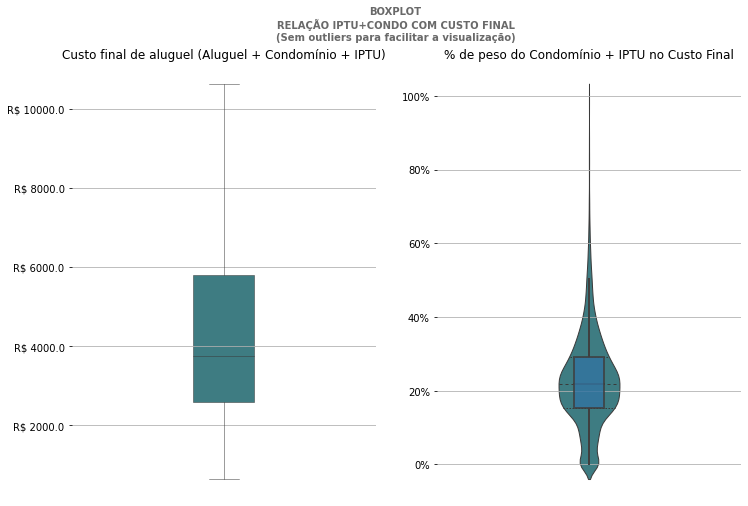

In [31]:
fig, axes = plt.subplots(1,2, sharex=True, figsize=(12,8))
#bplt = plt.figure()
bplt = sns.boxplot(ax=axes[0],data = db['fields.custo'],width=0.2, palette = 'crest',
                linewidth = 0.5,showfliers=False)
bplt = sns.violinplot(ax=axes[1],data = db['fields.condo_iptu']/db['fields.custo']*100,width=0.2, palette = 'crest',
                linewidth = 1,showfliers=False, inner='quartile')
bplt = sns.boxplot(ax=axes[1],data = db['fields.condo_iptu']/db['fields.custo']*100,width=0.1,
                linewidth = 2,showfliers=False, showcaps=False, boxprops={'alpha':0.8,"zorder":10}, whiskerprops={"zorder":10})


fig.suptitle('''BOXPLOT
RELAÇÃO IPTU+CONDO COM CUSTO FINAL
(Sem outliers para facilitar a visualização)''',
         fontsize = 10, color ='dimgrey', fontweight = 'bold')

axes[0].set_title("Custo final de aluguel (Aluguel + Condomínio + IPTU)")
axes[1].set_title("% de peso do Condomínio + IPTU no Custo Final")

sns.despine(bottom = True, left=True)

axes[0].grid(True)
axes[1].grid(True)

plt.xticks([])
axes[0].yaxis.set_major_formatter(mtick.StrMethodFormatter('R$ {x}'))
axes[1].yaxis.set_major_formatter(mtick.PercentFormatter())

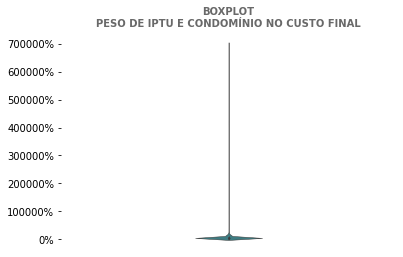

In [32]:
bplt = plt.figure()
bplt = sns.violinplot(data = db['fields.custo'],width=0.2, palette = 'crest',
                linewidth = 0.5,showfliers=False)


plt.title('''BOXPLOT
PESO DE IPTU E CONDOMÍNIO NO CUSTO FINAL''',
         fontsize = 10, color ='dimgrey', fontweight = 'bold')

sns.despine(bottom = True, left=True)

plt.xticks([])
bplt.yaxis.set_major_formatter(mtick.PercentFormatter())

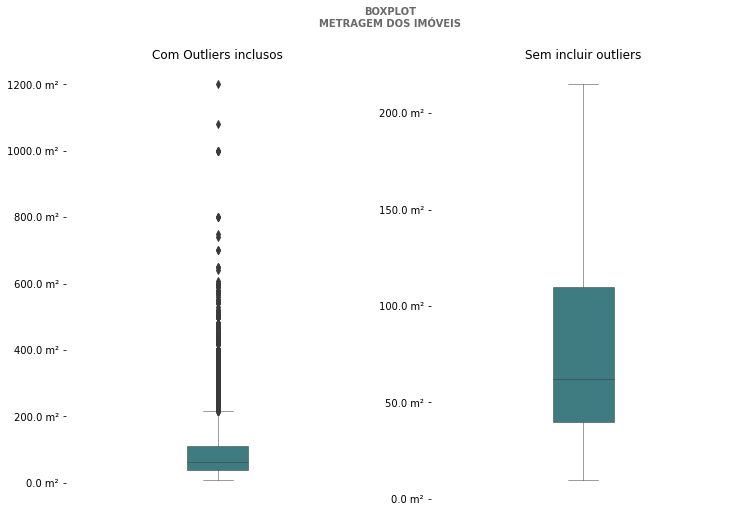

In [33]:
fig, axes = plt.subplots(1,2, sharex=True, figsize=(12,8))
bplt = sns.boxplot(ax=axes[0],data = db['fields.area'],width=0.2, palette = 'crest',
                linewidth = 0.5,showfliers=True)
bplt2 = sns.boxplot(ax=axes[1],data = db['fields.area'],width=0.2, palette = 'crest',
                linewidth = 0.5,showfliers=False)

fig.suptitle('''BOXPLOT
METRAGEM DOS IMÓVEIS''',
         fontsize = 10, color ='dimgrey', fontweight = 'bold')

axes[0].set_title("Com Outliers inclusos")
axes[1].set_title("Sem incluir outliers")

sns.despine(bottom = True, left=True)

plt.xticks([])
axes[0].yaxis.set_major_formatter(mtick.StrMethodFormatter('{x} m²'))
axes[1].yaxis.set_major_formatter(mtick.StrMethodFormatter('{x} m²'))

- Interpretação:
    Como esperado, a metragem mais comum de imóveis costuma ser de 40 à 100 m². Uma possibilidade de explicar a quantidade alta de outliers seria o caso de casas e apartementos "duplex" e "triplex".

#### Variáveis Categóricas

In [34]:
db[categoricas].describe(include=['object', 'bool'])

,fields.tipo,fields.for_rent,fields.cidade,fields.for_sale,fields.listing_tags,fields.regiao_nome
count,10029,10029,10029,10029,3312,10029
unique,4,1,1,2,11,84
top,Apartamento,True,São Paulo,False,"[""NEW_AD""]",Jardim Paulista
freq,7198,10029,10029,7632,1782,769


In [35]:
for i in categoricas:
    print(db[i].value_counts())
    printmd('*=============================================================================*')

Apartamento            7198
StudioOuKitchenette    1885
Casa                    884
CasaCondominio           62
Name: fields.tipo, dtype: int64


<span style='color:None'>*=============================================================================*</span>

True    10029
Name: fields.for_rent, dtype: int64


<span style='color:None'>*=============================================================================*</span>

São Paulo    10029
Name: fields.cidade, dtype: int64


<span style='color:None'>*=============================================================================*</span>

False    7632
True     2397
Name: fields.for_sale, dtype: int64


<span style='color:None'>*=============================================================================*</span>

["NEW_AD"]                                                                      1782
["RENT_PRICE_DECREASED"]                                                         931
["RENT_ON_TERMINATION","VISITS_UNAVAILABLE"]                                     325
["NEW_AD","RENT_PRICE_DECREASED"]                                                148
["RENT_ON_TERMINATION","NEW_AD","VISITS_UNAVAILABLE"]                             83
["RENT_ON_TERMINATION"]                                                           10
["NEW_AD","VISITS_UNAVAILABLE"]                                                   10
["VISITS_UNAVAILABLE"]                                                             9
["RENT_ON_TERMINATION","NEW_AD","RENT_PRICE_DECREASED","VISITS_UNAVAILABLE"]       8
["RENT_ON_TERMINATION","RENT_PRICE_DECREASED","VISITS_UNAVAILABLE"]                5
["RENT_PRICE_DECREASED","VISITS_UNAVAILABLE"]                                      1
Name: fields.listing_tags, dtype: int64


<span style='color:None'>*=============================================================================*</span>

Jardim Paulista          769
Bela Vista               631
Consolação               627
Santa Cecília            594
Moema                    440
                        ... 
Vila Amália                1
Chácara Santo Antonio      1
Vila Constança             1
Piqueri                    1
Vila Prado                 1
Name: fields.regiao_nome, Length: 84, dtype: int64


<span style='color:None'>*=============================================================================*</span>

Das variáveis categóricas, podemos extrair:
- Maioria esmagadora dos imóveis são apartamentos
- Confirmado que todos os dados são imóveis para alugar em **SP**
- A grande maioria dos imóveis não estão à venda
- temos 85 regiões registradas, o que nos abre margem para utilizá-las no ML como feature, talvez até importando dados externos do preço do m² na região

#### Outras

In [36]:
db[outras].describe(include=['object', 'bool'])

,fields.endereco
count,10029
unique,2551
top,Rua Bela Cintra
freq,103


#### Explorações extras

Vamos fazer alguns cruzamentos interessantes para explorar mais a fundo os dados:

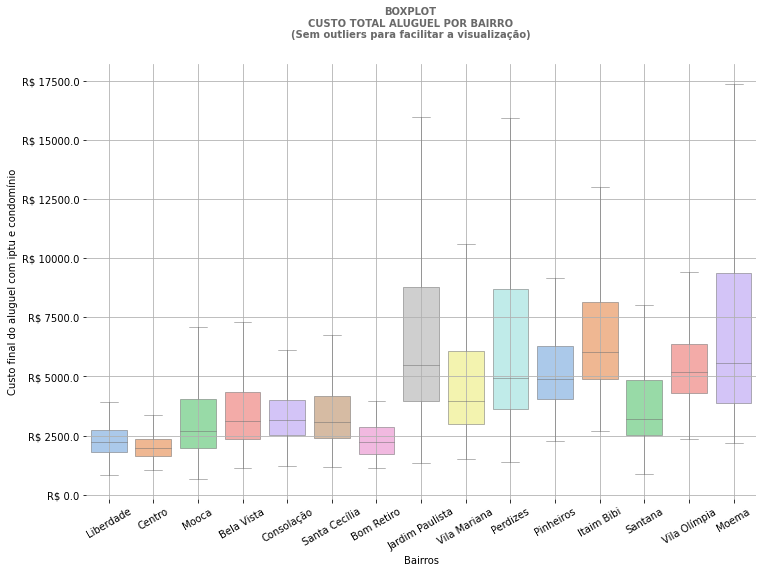

In [37]:
#Escolhemos os 15 bairros com mais anúncios

bairros = db['fields.regiao_nome'].value_counts().index.tolist()[:15]


fig = plt.figure( figsize=(12,8))
#bplt = plt.figure()
bplt = sns.boxplot(y='fields.custo',x='fields.regiao_nome' ,data = db[db['fields.regiao_nome'].isin(bairros)],
                   palette = 'pastel',linewidth = 0.5,showfliers=False)

fig.suptitle('''BOXPLOT
CUSTO TOTAL ALUGUEL POR BAIRRO
(Sem outliers para facilitar a visualização)''',
         fontsize = 10, color ='dimgrey', fontweight = 'bold')



sns.despine(bottom = True, left=True)

bplt.grid(True)
bplt.set_xlabel('Bairros')
bplt.set_ylabel('Custo final do aluguel com iptu e condomínio')
bplt.set_xticklabels(bplt.get_xticklabels(), rotation=30)
bplt.yaxis.set_major_formatter(mtick.StrMethodFormatter('R$ {x}'))


- Possível interpretação: <br>
    <span class="tex2jax_ignore">&emsp;A parentemente quanto maior a mediana de custo em um bairro, mais variam os mínimos e máximos também. Por exemplo, se comparar-mos o bairro da Mooca, que tem mediana de R$2.500,00 e o bairro de Moema, que tem mediana acima de R$5.000,00. É possivel perceber que em Moema os valores máximos e mínimos variam de ~R$1.500,00 até ~R$17.500,00, enquanto na Mooca, variam de ~R$1.250,00 até ~R$6.250,00</span>

## 3. Formulação das hipóteses

**A partir do exposto acima, acredito que posso formular algumas hipóteses sobre os dados. Explorar essas hipóteses me auxilia a entender melhor como esse dataset está formado e como as variáveis podem interagir entre si.**

- Hipótese 1: A metragem mais comum de imóveis costuma ser de 40 à 100 m². Uma possibilidade de explicar a quantidade alta de outliers seria o caso de casas e apartementos "duplex" e "triplex".
- Hipótese 2: O motivo da relação entre a variação dos custos e as medianas é por fato de bairros mais caros (mediana maior) serem bairros mais atrativos para a população, fazendo com que abram empreendimentos para mais classes sociais.
- Hipótese 3: Na verdade, o motivo do caso acima seria pela Área maior.
- Hipótese 4: O número de vagas tende a aumentar quando o número de quartos aumenta.

### Hipótese 1

Não poderemos ter certeza sobre apartamentos "duplex" e "triplex" pois não há nenhum campo que nos informe o dado, mas poderemos explorar a presença dos outliers por categorias StudioOuKitchenette, Casa e CasaCondominio. Com isso compararemos com a presença dos mesmos nos dados totais.

In [38]:
#fields.tipo
db['fields.tipo'].value_counts()

Apartamento            7198
StudioOuKitchenette    1885
Casa                    884
CasaCondominio           62
Name: fields.tipo, dtype: int64

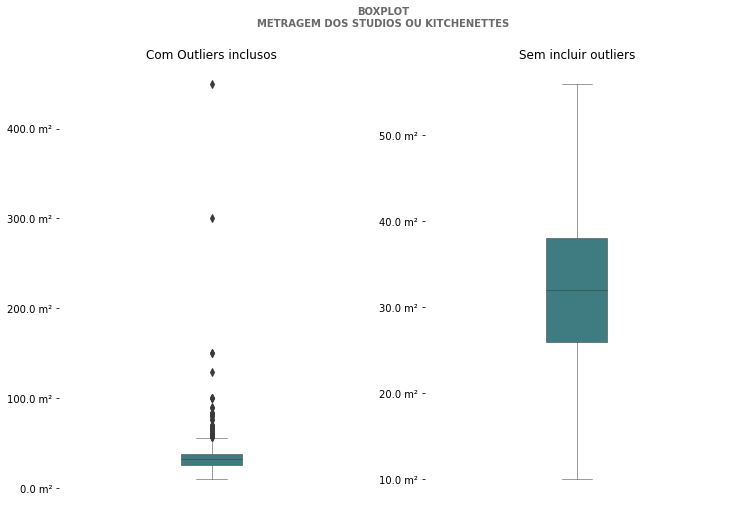

In [39]:
studioOuKtc = db[db['fields.tipo']=='StudioOuKitchenette']
studioOuKtc = db.rename(columns={'fields.tipo':'tipo'}).query('tipo in ["StudioOuKitchenette"]')
fig, axes = plt.subplots(1,2, sharex=True, figsize=(12,8))

bplt = sns.boxplot(ax=axes[0],data = studioOuKtc['fields.area'].to_frame(),width=0.2, palette = 'crest',
                linewidth = 0.5,showfliers=True)
bplt2 = sns.boxplot(ax=axes[1],data = studioOuKtc['fields.area'].to_frame(),width=0.2, palette = 'crest',
                linewidth = 0.5,showfliers=False)

fig.suptitle('''BOXPLOT
METRAGEM DOS STUDIOS OU KITCHENETTES''',
         fontsize = 10, color ='dimgrey', fontweight = 'bold')

axes[0].set_title("Com Outliers inclusos")
axes[1].set_title("Sem incluir outliers")

sns.despine(bottom = True, left=True)

plt.xticks([])
axes[0].yaxis.set_major_formatter(mtick.StrMethodFormatter('{x} m²'))
axes[1].yaxis.set_major_formatter(mtick.StrMethodFormatter('{x} m²'))

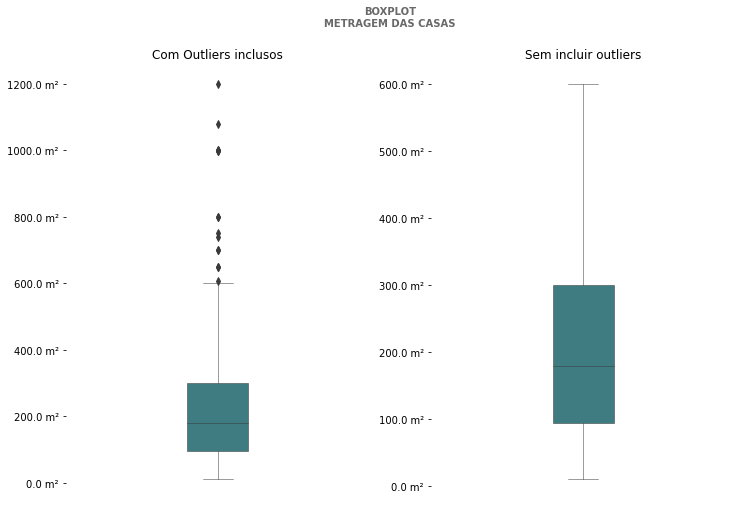

In [40]:
casa = db.rename(columns={'fields.tipo':'tipo'}).query('tipo in ["CasaCondominio","Casa"]')

fig, axes = plt.subplots(1,2, sharex=True, figsize=(12,8))
#bplt = plt.figure()

bplt = sns.boxplot(ax=axes[0],data = casa['fields.area'].reset_index()['fields.area'],width=0.2, palette = 'crest',
                linewidth = 0.5,showfliers=True)
bplt2 = sns.boxplot(ax=axes[1],data = casa['fields.area'].reset_index()['fields.area'],width=0.2, palette = 'crest',
                linewidth = 0.5,showfliers=False)

fig.suptitle('''BOXPLOT
METRAGEM DAS CASAS''',
         fontsize = 10, color ='dimgrey', fontweight = 'bold')

axes[0].set_title("Com Outliers inclusos")
axes[1].set_title("Sem incluir outliers")

sns.despine(bottom = True, left=True)

plt.xticks([])
axes[0].yaxis.set_major_formatter(mtick.StrMethodFormatter('{x} m²'))
axes[1].yaxis.set_major_formatter(mtick.StrMethodFormatter('{x} m²'))

##### Comparando o número de outliers dos três

In [41]:
printmd('**Max e Min da fields.area dos dados totais:**')
Q1 = db.quantile(0.25)
Q3 = db.quantile(0.75)
IQR = Q3 - Q1
print((Q1 - 1.5 * IQR)['fields.area'])
print((Q3 + 1.5 * IQR)['fields.area'])
outliers =db[db['fields.area']<-56.5].count()['fields.area'] + db[db['fields.area']>195.5].count()['fields.area']
printmd('**Número de outliers presentes nessa coluna:** {outliers}'.format(outliers=outliers))
a = outliers / db['fields.area'].count() * 100
printmd('**Porcentagem de outliers sobre o número total de dados selecionados:** {a}%'.format(a=a.round(2)))

printmd('*===========================*')
printmd('**Max e Min da fields.area dos dados após filtragem por somente Studio e Kits:**')

Q1 = studioOuKtc.quantile(0.25)
Q3 = studioOuKtc.quantile(0.75)
IQR = Q3 - Q1
print((Q1 - 1.5 * IQR)['fields.area'])
print((Q3 + 1.5 * IQR)['fields.area'])
outliers =studioOuKtc[studioOuKtc['fields.area']<9.5].count()['fields.area'] + studioOuKtc[studioOuKtc['fields.area']>53.5].count()['fields.area']
printmd('**Número de outliers presentes nessa coluna:** {outliers}'.format(outliers=outliers))
a = outliers / studioOuKtc['fields.area'].count() * 100
printmd('**Porcentagem de outliers sobre o número total de dados selecionados:** {a}%'.format(a=a.round(2)))

printmd('*===========================*')
printmd('**Max e Min da fields.area dos dados após filtragem por somente Casas:**')

Q1 = casa.quantile(0.25)
Q3 = casa.quantile(0.75)
IQR = Q3 - Q1
print((Q1 - 1.5 * IQR)['fields.area'])
print((Q3 + 1.5 * IQR)['fields.area'])
outliers =casa[casa['fields.area']<9.5].count()['fields.area'] + casa[casa['fields.area']>53.5].count()['fields.area']
printmd('**Número de outliers presentes nessa coluna:** {outliers}'.format(outliers=outliers))
a = outliers / casa['fields.area'].count() * 100
printmd('**Porcentagem de outliers sobre o número total de dados selecionados:** {a}%'.format(a=a.round(2)))

#casa['fields.area'].reset_index()['fields.area']

<span style='color:None'>**Max e Min da fields.area dos dados totais:**</span>

-65.0
215.0


<span style='color:None'>**Número de outliers presentes nessa coluna:** 1090</span>

<span style='color:None'>**Porcentagem de outliers sobre o número total de dados selecionados:** 10.87%</span>

<span style='color:None'>*===========================*</span>

<span style='color:None'>**Max e Min da fields.area dos dados após filtragem por somente Studio e Kits:**</span>

8.0
56.0


<span style='color:None'>**Número de outliers presentes nessa coluna:** 51</span>

<span style='color:None'>**Porcentagem de outliers sobre o número total de dados selecionados:** 2.71%</span>

<span style='color:None'>*===========================*</span>

<span style='color:None'>**Max e Min da fields.area dos dados após filtragem por somente Casas:**</span>

-212.5
607.5


<span style='color:None'>**Número de outliers presentes nessa coluna:** 833</span>

<span style='color:None'>**Porcentagem de outliers sobre o número total de dados selecionados:** 88.05%</span>

Podemos afirmar que a hipótese parcialmente se confirma, pois apesar de não conseguirmos comprovar a parte de Apartamentos "duplex" e "triplex", comprovamos que Studios e Kitcheneettes contém uma porcentagem muito menor de outliers do que o dataset total, e muito menor ainda do que Casas:


|  | Dataset Total | Casas | StudiosOuKits |
|-|-|-|-|
| **% de outliers** | 9.4 | 91.01 | 2.75 |


### Hipótese 4

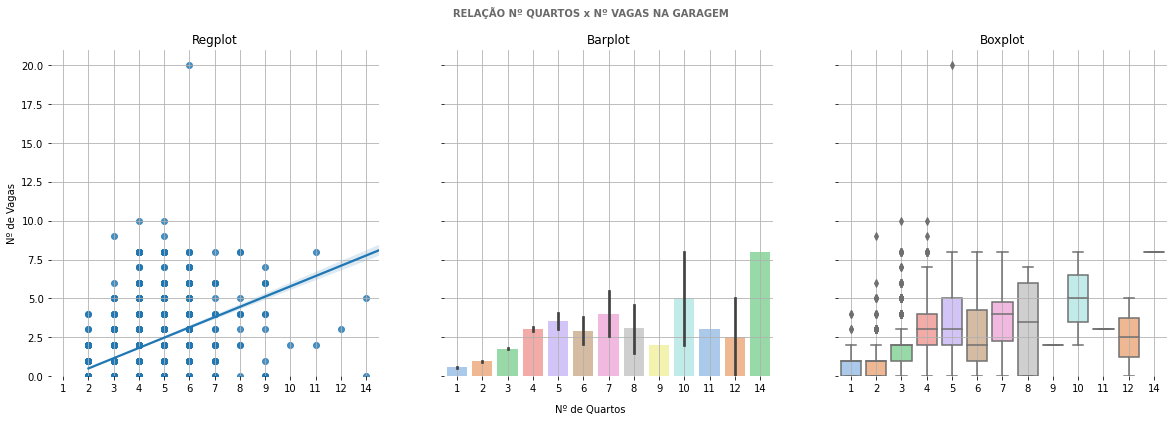

In [42]:
fig, axes = plt.subplots(1,3, sharex=True, sharey=True, figsize=(20,6))
#bplt = plt.figure()
regplot = sns.regplot(ax=axes[0], y='fields.vagas',x='fields.quartos',data = db)#,
#                   palette = 'pastel')
barplot = sns.barplot(ax=axes[1], y='fields.vagas',x='fields.quartos',data = db,
                   palette = 'pastel')
bplt = sns.boxplot(ax=axes[2], y='fields.vagas',x='fields.quartos',data = db,
                   palette = 'pastel')

fig.suptitle('''RELAÇÃO Nº QUARTOS x Nº VAGAS NA GARAGEM''',
         fontsize = 10, color ='dimgrey', fontweight = 'bold')

axes[0].set_title("Regplot")
axes[1].set_title("Barplot")
axes[2].set_title("Boxplot")

sns.despine(bottom = True, left=True)

#plt.xticks([])
#plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
axes[0].set_ylabel('Nº de Vagas')
fig.text(0.5, 0.04, 'Nº de Quartos', ha='center')
for i in axes:
    i.grid(True)
    i.set_xlabel("")
    if i!=axes[0]:
        i.set_ylabel("")

Interpretação:<br>
    &#9; Existe uma tendência de crescimento do número de vagas disponíveis com o crescimento do número de quartos dos imóveis até 5 quartos. Após isso, a tendência perde força e varia mais, sem demonstrar muita relação. Porém, se olharmos o crescimento do número de Quartos em função do número de Vagas, algo inesperado ocorre:<br> 
    &#9; **Vemos uma tendência de crescimento mais definida e constante.**

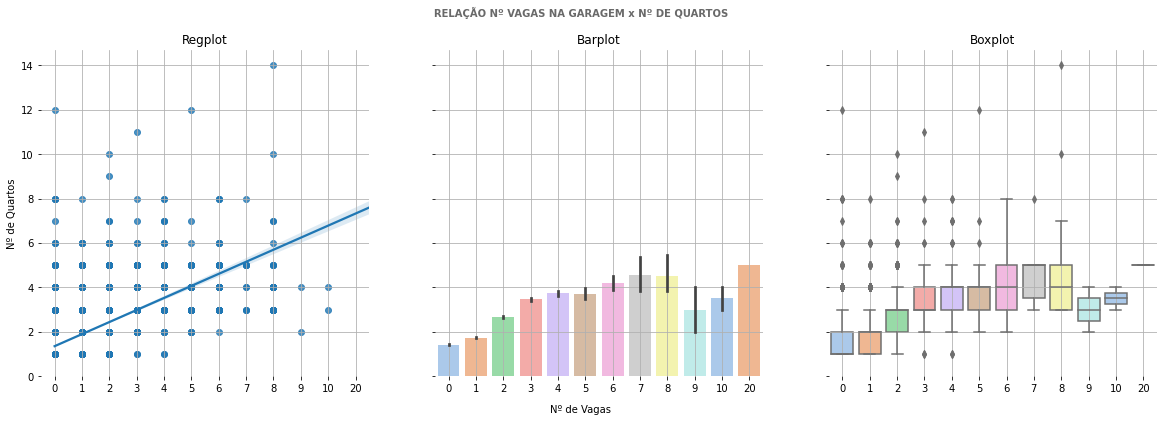

In [43]:
fig, axes = plt.subplots(1,3, sharex=True, sharey=True, figsize=(20,6))
#bplt = plt.figure()
regplot = sns.regplot(ax=axes[0], y='fields.quartos',x='fields.vagas',data = db)#,
#                   palette = 'pastel')
barplot = sns.barplot(ax=axes[1], y='fields.quartos',x='fields.vagas',data = db,
                   palette = 'pastel')
bplt = sns.boxplot(ax=axes[2], y='fields.quartos',x='fields.vagas',data = db,
                   palette = 'pastel')

fig.suptitle('''RELAÇÃO Nº VAGAS NA GARAGEM x Nº DE QUARTOS''',
         fontsize = 10, color ='dimgrey', fontweight = 'bold')

axes[0].set_title("Regplot")
axes[1].set_title("Barplot")
axes[2].set_title("Boxplot")

sns.despine(bottom = True, left=True)

#plt.xticks([])
#plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
axes[0].set_ylabel('Nº de Quartos')
fig.text(0.5, 0.04, 'Nº de Vagas', ha='center')
for i in axes:
    i.grid(True)
    i.set_xlabel("")
    if i!=axes[0]:
        i.set_ylabel("")

## 4. Seleção de features para Machine Learning

In [44]:
numericas
#vamos dropar sale_price e custo. aluguel será nosso Target

['fields.quartos',
 'fields.area',
 'fields.sale_price',
 'fields.aluguel',
 'fields.custo',
 'fields.condo_iptu',
 'fields.vagas']

In [45]:
categoricas

['fields.tipo',
 'fields.for_rent',
 'fields.cidade',
 'fields.for_sale',
 'fields.listing_tags',
 'fields.regiao_nome']

In [46]:
#precisaremos transformar as categóricas em valores numéricos para o ML funcionar

for i in categoricas:
    print(i)
    print(db[i].unique(), '\n')
    
#iremos dropar for_rent, cidade e for_sale

fields.tipo
['Apartamento' 'StudioOuKitchenette' 'Casa' 'CasaCondominio'] 

fields.for_rent
[ True] 

fields.cidade
['São Paulo'] 

fields.for_sale
[ True False] 

fields.listing_tags
['["NEW_AD"]' '["RENT_ON_TERMINATION","NEW_AD","VISITS_UNAVAILABLE"]'
 '["NEW_AD","RENT_PRICE_DECREASED"]' nan
 '["RENT_ON_TERMINATION","VISITS_UNAVAILABLE"]'
 '["RENT_ON_TERMINATION","NEW_AD","RENT_PRICE_DECREASED","VISITS_UNAVAILABLE"]'
 '["RENT_PRICE_DECREASED"]' '["VISITS_UNAVAILABLE"]'
 '["NEW_AD","VISITS_UNAVAILABLE"]'
 '["RENT_ON_TERMINATION","RENT_PRICE_DECREASED","VISITS_UNAVAILABLE"]'
 '["RENT_ON_TERMINATION"]' '["RENT_PRICE_DECREASED","VISITS_UNAVAILABLE"]'] 

fields.regiao_nome
['Liberdade' 'Centro' 'Mooca' 'Bela Vista' 'Consolação' 'Santa Cecília'
 'Aclimação' 'Brás' 'Cambuci' 'Higienópolis' 'Barra Funda' 'Bom Retiro'
 'Jardim Paulista' 'Paraíso' 'Vila Mariana' 'Perdizes' 'Pacaembu'
 'Pinheiros' 'Ipiranga' 'Belém' 'Casa Verde' 'Itaim Bibi' 'Sumaré'
 'Vila Guilherme' 'Canindé' 'Vila Pompéia' '

In [47]:
db2 = db.copy()

In [48]:
#Selecionando nossas colunas para conferimos as correlações
newCols = ['fields.quartos',
 'fields.area',
 'fields.aluguel',
 'fields.condo_iptu',
 'fields.vagas',
 'fields.tipo',
 'fields.listing_tags',
 'fields.regiao_nome']
db2 = db2[newCols]

db2.columns

Index(['fields.quartos', 'fields.area', 'fields.aluguel', 'fields.condo_iptu',
       'fields.vagas', 'fields.tipo', 'fields.listing_tags',
       'fields.regiao_nome'],
      dtype='object')

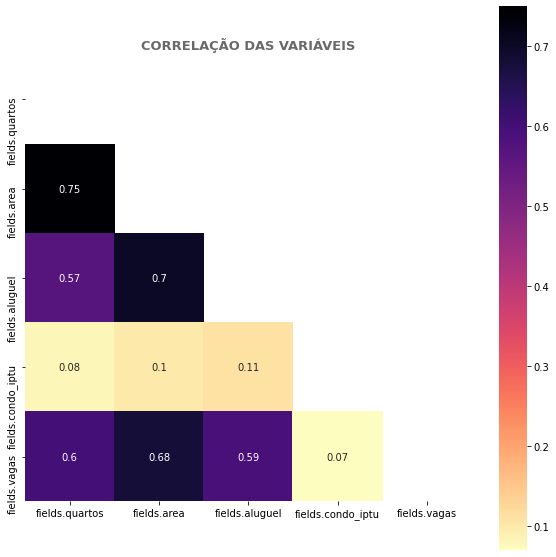

In [49]:
d = db2.corr().round(2)

# Plotando gráfico
plt.figure(figsize=(10, 10))

mask = np.triu(np.ones_like(d, dtype=bool))
sns.heatmap(d, annot = True, square = True, mask = mask, cmap = 'magma_r')

plt.title('CORRELAÇÃO DAS VARIÁVEIS', fontsize = 13, color ='dimgrey', fontweight = 'bold')

sns.despine(bottom = True, left=True)

In [50]:
label_encoder = LabelEncoder()
ohe = OneHotEncoder()
tipoMap = {"StudioOuKitchenette":0, "Apartamento":1,"CasaCondominio":2, "Casa":3}
db2 = pd.get_dummies(db2, prefix='one_hot', columns=['fields.listing_tags', 'fields.regiao_nome'])
db2['fields.tipo'].replace(tipoMap, inplace=True)
print(db2.columns)

Index(['fields.quartos', 'fields.area', 'fields.aluguel', 'fields.condo_iptu',
       'fields.vagas', 'fields.tipo',
       'one_hot_["NEW_AD","RENT_PRICE_DECREASED"]',
       'one_hot_["NEW_AD","VISITS_UNAVAILABLE"]', 'one_hot_["NEW_AD"]',
       'one_hot_["RENT_ON_TERMINATION","NEW_AD","RENT_PRICE_DECREASED","VISITS_UNAVAILABLE"]',
       ...
       'one_hot_Vila Prado', 'one_hot_Vila Prudente', 'one_hot_Vila Romana',
       'one_hot_Vila Roque', 'one_hot_Vila Santa Clara',
       'one_hot_Vila Santa Maria', 'one_hot_Vila Santista',
       'one_hot_Vila das Mercês', 'one_hot_Água Branca', 'one_hot_Água Fria'],
      dtype='object', length=101)


### Testando Boruta para selecionar as features

Aqui testarei a utilização do algoritmo BorutaPy, mesmo sabendo que nesse caso ele não será muito útil pela baixa quantidade de dados.
Utilizarem a versão dos dados antes da aplicação do algoritmo OneHotEncoding, pois essas colunas vão pedir uma quantidade muito grande de memória e processamento do computador

In [51]:
cols = ['fields.quartos', 'fields.area', 'fields.aluguel', 'fields.condo_iptu', 'fields.vagas', 'fields.tipo']
db3 = db[cols]
db3['fields.tipo'].replace(tipoMap, inplace=True)
db3.columns

Index(['fields.quartos', 'fields.area', 'fields.aluguel', 'fields.condo_iptu',
       'fields.vagas', 'fields.tipo'],
      dtype='object')

In [52]:
cols = db3.columns.to_list()
print(cols)
#cols = ['fields.quartos', 'fields.area', 'fields.aluguel', 'fields.condo_iptu', 'fields.vagas', 'fields.tipo']
for i in ['fields.aluguel']:
    cols.remove(i)
    
X = db3[cols].values
y = db3['fields.aluguel'].values.ravel()


['fields.quartos', 'fields.area', 'fields.aluguel', 'fields.condo_iptu', 'fields.vagas', 'fields.tipo']


In [53]:
gc.collect()

44357

In [54]:
# Define o algoritmo random forest classifier, usando todos os cores do CPU
rf = RandomForestClassifier(n_jobs=-1)

# Definir o método para Feature Selection que o Boruta vai utilizar
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=1, random_state=23)

# Encontrar as features relevantes
feat_selector.fit(X, y)

# Conferir as features elecionadas
filtered_list = [i for (i, v) in zip(cols, feat_selector.support_) if v]
printmd("**Features escolhidas pelo algoritmo:** {features}".format(features=filtered_list))


# Poderiamos chamar a função transform() no X para filtrar para somente as features escolhidas
# X_filtered = feat_selector.transform(X)


Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	0
Rejected: 	4


<span style='color:None'>**Features escolhidas pelo algoritmo:** ['fields.condo_iptu']</span>

Como falado antes, o algoritmo não vai sugerir a seleção de colunas de modo útil ou bastante funcional para esse projeto pois a quantidade de dados não está próxima do perfeito. Porém, é sempre bom testar e entender como aplicá-lo, principalmente em projetos como esse!

## 5. Teste de diversos algoritmos de Machine Learning

In [55]:
cols = db2.columns.to_list()
print(cols)
cols.remove('fields.aluguel')
X = db2[cols]
y = db2['fields.aluguel']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=db2['fields.tipo'])




['fields.quartos', 'fields.area', 'fields.aluguel', 'fields.condo_iptu', 'fields.vagas', 'fields.tipo', 'one_hot_["NEW_AD","RENT_PRICE_DECREASED"]', 'one_hot_["NEW_AD","VISITS_UNAVAILABLE"]', 'one_hot_["NEW_AD"]', 'one_hot_["RENT_ON_TERMINATION","NEW_AD","RENT_PRICE_DECREASED","VISITS_UNAVAILABLE"]', 'one_hot_["RENT_ON_TERMINATION","NEW_AD","VISITS_UNAVAILABLE"]', 'one_hot_["RENT_ON_TERMINATION","RENT_PRICE_DECREASED","VISITS_UNAVAILABLE"]', 'one_hot_["RENT_ON_TERMINATION","VISITS_UNAVAILABLE"]', 'one_hot_["RENT_ON_TERMINATION"]', 'one_hot_["RENT_PRICE_DECREASED","VISITS_UNAVAILABLE"]', 'one_hot_["RENT_PRICE_DECREASED"]', 'one_hot_["VISITS_UNAVAILABLE"]', 'one_hot_Aclimação', 'one_hot_Alto de Pinheiros', 'one_hot_Barra Funda', 'one_hot_Bela Vista', 'one_hot_Belém', 'one_hot_Bom Retiro', 'one_hot_Bosque da Saúde', 'one_hot_Brooklin', 'one_hot_Brás', 'one_hot_Butantã', 'one_hot_Cambuci', 'one_hot_Campo Belo', 'one_hot_Canindé', 'one_hot_Casa Verde', 'one_hot_Casa Verde Alta', 'one_hot_Ce

- Vamos comparar os resultados dos algoritmos: LinearRegression, Ridge, RidgeCV

In [56]:
def linear(X_train, X_test, y_train, y_test):
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    pred = (lr.predict(X_test) - y_test).abs()
    print("LinearRegression has an error rate of R$",pred.describe()['mean'])
    score = [lr.score(X_train, y_train),lr.score(X_test, y_test)]
    return "LinearRegression made a {score1} score in train and a {score2} in test.".format(score1=score[0].round(3),
                                                                                            score2=score[1].round(3))

In [57]:
def ridge(X_train, X_test, y_train, y_test):
    clf = make_pipeline(StandardScaler(), Ridge(alpha=1.0, random_state=42))
    clf.fit(X_train, y_train)
    pred = (clf.predict(X_test) - y_test).abs()
    print("RidgeRegression has an error rate of R$",pred.describe()['mean'])
    score = [clf.score(X_train, y_train),clf.score(X_test, y_test)]
    return "Ridge Regression made a {score1} score in train and a {score2} in test.".format(score1=score[0].round(3),
                                                                                            score2=score[1].round(3))

In [58]:
def ridgeCV(X_train, X_test, y_train, y_test):
    rid = make_pipeline(StandardScaler(),PolynomialFeatures(degree=2), RidgeCV())
    rid.fit(X_train, y_train)
    pred = (rid.predict(X_test) - y_test).abs()
    print("RidgeCV has an error rate of R$",pred.describe()['mean'])
    score = [rid.score(X_train, y_train),rid.score(X_test, y_test)]
    return "RidgeCV made a {score1} score in train and a {score2} in test.".format(score1=score[0].round(3),
                                                                                            score2=score[1].round(3))

In [59]:
gc.collect()

326

In [60]:
for i in [linear, ridge, ridgeCV]:
    print(i(X_train, X_test, y_train, y_test))

LinearRegression has an error rate of R$ 1100.221590268911
LinearRegression made a 0.63 score in train and a 0.627 in test.
RidgeRegression has an error rate of R$ 1100.4272404326289
Ridge Regression made a 0.63 score in train and a 0.627 in test.
RidgeCV has an error rate of R$ 1138.1448689516485
RidgeCV made a 0.731 score in train and a 0.028 in test.


### Testando algumas opções de exclusão de dados categóricos e comparando resultados

+ Excluindo o tipo de imóvel `CasaCondominio` 

In [61]:
gc.collect()

44

In [62]:
#{"StudioOuKitchenette":0, "Apartamento":1,"CasaCondominio":2, "Casa":3}

db3 = db2.loc[(db2['fields.tipo']==0) | (db2['fields.tipo']==1) | (db2['fields.tipo']==2)]

cols = db3.columns.to_list()

cols.remove('fields.aluguel')
X = db3[cols]
y = db3['fields.aluguel']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.33, random_state=42, stratify=db3['fields.tipo'])

In [63]:
for i in [linear, ridge, ridgeCV]:
    print(i(X_train2, X_test2, y_train2, y_test2))

LinearRegression has an error rate of R$ 1030.170999311599
LinearRegression made a 0.636 score in train and a 0.621 in test.
RidgeRegression has an error rate of R$ 1031.0140073845093
Ridge Regression made a 0.636 score in train and a 0.62 in test.
RidgeCV has an error rate of R$ 1106.2228582332152
RidgeCV made a 0.716 score in train and a -2.268 in test.


+ Mantendo somente os tipos de imóveis `StudioOuKitchenette` e `Apartamento`

In [64]:
gc.collect()

22

In [65]:
#{"StudioOuKitchenette":0, "Apartamento":1,"CasaCondominio":2, "Casa":3}

db3 = db2.loc[(db2['fields.tipo']==0) | (db2['fields.tipo']==1)]
cols = db3.columns.to_list()
cols.remove('fields.aluguel')
X = db3[cols]
y = db3['fields.aluguel']


X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size=0.33, random_state=42, stratify=db3['fields.tipo'])

In [66]:
for i in [linear, ridge, ridgeCV]:
    print(i(X_train3, X_test3, y_train3, y_test3))

LinearRegression has an error rate of R$ 1032.0306405182027
LinearRegression made a 0.634 score in train and a 0.62 in test.
RidgeRegression has an error rate of R$ 1032.8527773067328
Ridge Regression made a 0.634 score in train and a 0.62 in test.
RidgeCV has an error rate of R$ 1094.4678775089906
RidgeCV made a 0.714 score in train and a -1.521 in test.


+ Mantendo somente o tipo de imóvel `Apartamento` 

In [67]:
gc.collect()

22

In [68]:
#{"StudioOuKitchenette":0, "Apartamento":1,"CasaCondominio":2, "Casa":3}
db3 = db2.loc[(db2['fields.tipo']==1)]
cols = db3.columns.to_list()
cols.remove('fields.aluguel')
X = db3[cols]
y = db3['fields.aluguel']


X_train4, X_test4, y_train4, y_test4 = train_test_split(X, y, test_size=0.33, random_state=42, stratify=db3['fields.tipo'])

In [69]:
for i in [linear, ridge, ridgeCV]:
    print(i(X_train4, X_test4, y_train4, y_test4))

LinearRegression has an error rate of R$ 1136.909187907563
LinearRegression made a 0.626 score in train and a 0.597 in test.
RidgeRegression has an error rate of R$ 1138.0624788378782
Ridge Regression made a 0.626 score in train and a 0.597 in test.
RidgeCV has an error rate of R$ 1128.8500995977772
RidgeCV made a 0.701 score in train and a 0.611 in test.


+ Mantendo somente o tipo de imóvel `StudioOuKitchenette` 

In [70]:
gc.collect()

22

In [71]:
#{"StudioOuKitchenette":0, "Apartamento":1,"CasaCondominio":2, "Casa":3}

db3 = db2.loc[(db2['fields.tipo']==0)]
cols = db3.columns.to_list()
cols.remove('fields.aluguel')
X = db3[cols]
y = db3['fields.aluguel']


X_train5, X_test5, y_train5, y_test5 = train_test_split(X, y, test_size=0.33, random_state=42, stratify=db3['fields.tipo'])

In [72]:
for i in [linear, ridge, ridgeCV]:
    print(i(X_train5, X_test5, y_train5, y_test5))

LinearRegression has an error rate of R$ 603.4984091300288
LinearRegression made a 0.531 score in train and a 0.457 in test.
RidgeRegression has an error rate of R$ 604.6345158548531
Ridge Regression made a 0.531 score in train and a 0.456 in test.
RidgeCV has an error rate of R$ 779.3340732153624
RidgeCV made a 0.754 score in train and a -10.263 in test.


+ Mantendo somente os tipos de imóveis `CasaCondominio` e `Casa`

In [73]:
#{"StudioOuKitchenette":0, "Apartamento":1,"CasaCondominio":2, "Casa":3}

db3 = db2.loc[(db2['fields.tipo']==2) | (db2['fields.tipo']==3)]
cols = db3.columns.to_list()
cols.remove('fields.aluguel')
X = db3[cols]
y = db3['fields.aluguel']


X_train6, X_test6, y_train6, y_test6 = train_test_split(X, y, test_size=0.33, random_state=42, stratify=db3['fields.tipo'])

In [74]:
for i in [linear, ridge, ridgeCV]:
    print(i(X_train6, X_test6, y_train6, y_test6))

LinearRegression has an error rate of R$ 1582.6361231442368
LinearRegression made a 0.726 score in train and a 0.662 in test.
RidgeRegression has an error rate of R$ 1582.4421662264776
Ridge Regression made a 0.726 score in train and a 0.663 in test.
RidgeCV has an error rate of R$ 2147.3427549879493
RidgeCV made a 0.871 score in train and a 0.318 in test.


+ Comparação entre os melhores resultados de cada
| Tipos includos | Melhor resultado (R² score) | Erro em R$ |
|--|--|--|
|Todos os tipos|0.627|1100.22|
|StudioOuKitchenette, Apartamento e Casa|0.621|1030.17|
|StudioOuKitchenette e Apartamento|0.62|1032.85|
|Apartamento|0.611|1128.85|
|StudioOuKitchenette|0.457|603.49|
|CasaCondominio e Casa|0.663|1582.44|

## 6. Criação de um Pipeline para deploy

Por ora, criaremos um Pipeline e função de pré-processamento a partir do feito acima, o que nos permitiria utilizar o algoritmo em um sistem automatizado. Por ora escolheremos o algoritmo que teve melhor resultado R² entre os três primeiros, uma vez que será importânte manter a categoria `Apartamentos` no algoritmo por ser a mais anunciada, que será:
+ RidgeRegression com dados de todos os tipos de imóveis

In [75]:
def transformData(data):
    data = data[[
        'fields.quartos',        
        'fields.area',
        'fields.aluguel',
        'fields.condo_iptu',
        'fields.vagas',
        'fields.tipo',
        'fields.listing_tags',
        'fields.regiao_nome'
    ]]
    
    tipoMap={"StudioOuKitchenette":0, "Apartamento":1,"CasaCondominio":2, "Casa":3}
    data['fields.tipo'].replace(tipoMap, inplace=True)
    data = data[data['fields.tipo'].map(lambda x: int(x) in [0,1,3])]
    if len(data) < 1:
        raise ValueError("Imóvel não é do tipo suportado")
    data['fields.listing_tags'].replace({np.nan:''}, inplace=True)
    data['fields.quartos'] = data['fields.quartos'].astype('int64')
    data['fields.condo_iptu'] = data['fields.condo_iptu'].astype('float')
    data['fields.vagas'] = data['fields.vagas'].astype('int64')
    for i in data.columns:
        if data[i].isnull().any():
            print(i)
    data = pd.get_dummies(data, prefix='one_hot', columns=['fields.listing_tags', 'fields.regiao_nome'])
    #print(data.columns)
    return data

In [77]:
db_pipe = pd.read_csv('../CSV/aluguel_unique.csv')
db_pipe = transformData(db)
cols = db_pipe.columns.to_list()

X = db_pipe.drop(['fields.aluguel'],axis=1)
y = db_pipe['fields.aluguel']



arrays = [X, y]
lengths = [len(X) for X in arrays if X is not None]



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=X['fields.tipo'])




In [78]:
def addMissingCols(data):
    cols = transformData(db).columns.tolist()
    
    return data.reindex(columns=cols, fill_value=0)

In [79]:
Pipeline = make_pipeline(
    FunctionTransformer(addMissingCols),
    StandardScaler(),
    PolynomialFeatures(degree=2),
    Ridge()
)
Pipeline.fit(X_train, y_train)
#pred = (Pipeline.predict(X_test) - y_test).abs()
#print("RidgeCV has an error rate of R$",pred.describe()['mean'])
#score = rid.score(X_test, y_test)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function addMissingCols at 0x000001EA76039820>)),
                ('standardscaler', StandardScaler()),
                ('polynomialfeatures', PolynomialFeatures()),
                ('ridge', Ridge())])

+ Dados do meu apartamento fictício:
    + Quartos: 2
    + Area: 47m²
    + Condo+IPTU:
    + Vagas: 1
    + Tipo: Apartamento

In [80]:
np.sort(db['fields.regiao_nome'].unique())

array(['Aclimação', 'Alto de Pinheiros', 'Barra Funda', 'Bela Vista',
       'Belém', 'Bom Retiro', 'Bosque da Saúde', 'Brooklin', 'Brás',
       'Butantã', 'Cambuci', 'Campo Belo', 'Canindé', 'Casa Verde',
       'Casa Verde Alta', 'Centro', 'Chácara Inglesa',
       'Chácara Santo Antonio', 'Cidade Jardim', 'Consolação',
       'Freguesia do Ó', 'Higienópolis', 'Ipiranga', 'Itaim Bibi',
       'Jabaquara', 'Jardim América', 'Jardim Anália Franco',
       'Jardim Avelino', 'Jardim Brasil', 'Jardim Europa',
       'Jardim Guedala', 'Jardim Independência', 'Jardim Paulista',
       'Jardim Paulistano', 'Jardim Santa Emília', 'Lapa', 'Liberdade',
       'Mandaqui', 'Moema', 'Mooca', 'Pacaembu', 'Paraíso', 'Pari',
       'Parque Novo Mundo', 'Perdizes', 'Pinheiros', 'Piqueri',
       'Planalto Paulista', 'Real Parque', 'Sacomã', 'Santa Cecília',
       'Santana', 'Saúde', 'Sumaré', 'São João Clímaco',
       'Sítio do Mandaqui', 'Tatuapé', 'Vila Amália', 'Vila Clementino',
       'Vila Co

In [81]:
apartamento = pd.DataFrame(data={'fields.quartos':[2],
                           'fields.area':[47],
                           'fields.aluguel':[0],
                           'fields.condo_iptu':[350],
                           'fields.vagas':[1],
                           'fields.tipo':['Apartamento'],
                           'fields.regiao_nome':['Vila Mariana'],
                           'fields.listing_tags':['']
                           })


apartamento = transformData(apartamento)
apartamento = addMissingCols(apartamento)

X_apartamento = apartamento.drop(['fields.aluguel'], axis=1)
y_apartamento = apartamento['fields.aluguel']
apartamento_pred = str(Pipeline.predict(X_apartamento)[0].round(2)).replace('.', ',')
print("Seu imóvel deve ser anunciado, segundo o mercado, pelo valor de: R${pred}".format(pred=apartamento_pred))


Seu imóvel deve ser anunciado, segundo o mercado, pelo valor de: R$2555,52


## 7. Conclusão

Com esse projeto, foi possível aprender importantes lições de Análise e Ciência de Dados:
+ Mesmo com bom tratamento e feature engineering, a quantidade total de dados vai ter grande peso no resultado e acurácia finais.
+ Uma análise exploratória profunda, e muitas vezes, criativa, auxilia muito no entendimento dos dados, além de abrir chances para correções de inconsistências logo no inicio do processo.
+ Os dados, mesmo que vindo de uma API de produção consistente, sempre devem ser revisados e conferidos em busca de erros de tipagem, de digitação, entre outros.
+ A forma como se dá a apresentação do processo de pensamento e geração de insights deve ser cuidadosamente trabalhada para garantir passar a mensagem corretamente para futuros leitores e revisadores do projeto.

Além disso, o projeto acima me auxiliou a definir os próximos focos de estudo:
+ Storytelling de Dados
+ Feature Engineering


Ideias para explorar nesse projeto futuramente:
+ K Means com análise geoespacial dos Imóveis e seus valores